# Analyze Data from MPI Experiment
This file can be used to calculate the Jensen-Shannon distance between the human and model distributions. Currently, this file uses results created from LLaMA (7b) and LLaMA Chat (7b). 

**The only change you need to make is the output directory in the first code box below "Import Results".**

In [30]:
# Import Results
# Change the directory to point to the results for your models
import torch
pre_aligned_model = torch.load('./output/mpi/llama2_7B_mpi',map_location=torch.device('cpu'))
post_aligned_model = torch.load('./output/mpi/llama2_7B_chat_mpi',map_location=torch.device('cpu'))

In [31]:
#Import Human Data
import pandas as pd
# This takes a few minutes to download, it is a big file!
human_resp = pd.read_csv("./data/mpi_human_resp.csv").iloc[:, -120:]
key = pd.read_csv("./data/mpi_questions.csv", delimiter="\t")


In [32]:
# Need to remap some questions which were labelled backwards on the original survey
def remap_values(column, key_value):
    if key_value == 1:
        return column
    elif key_value == -1:
        mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
        return column.map(mapping)
# Apply remapping function to each column in 'human_resp' DataFrame
for i,column in enumerate(human_resp.columns):
    key_value = key['key'][i]
    human_resp[column] = remap_values(human_resp[column], key_value)

In [33]:
# Calculate human distribution for each test
human_distr_df = {}
# Iterate over columns in the DataFrame
for i, column in enumerate(human_resp):
    # Get value counts for each column
    value_counts = human_resp[column].value_counts().to_list()
    # Calculate probability distribution by dividing by the sum
    total_values = sum(value_counts[1:]) # we ignore values of 0 = ppl who did not answer
    probability_distribution = {value / total_values for value in value_counts[1:]} # we ignore values of 0 = ppl who did not answer
    # Convert the probability distribution dictionary to a list of tuples
    probability_list = probability_distribution
    # Add the list to the dictionary with column name as key
    human_distr_df[i] = probability_list

In [34]:
# Calculate the Jensens-Shannon Distance
from scipy.spatial import distance
import numpy as np
import random
random.seed(1)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def calc_metrics(results_df):
    distance_model_human = []
    distance_model_shuffle_human = []
    entropy_human = []
    entropy_model = []
    for i, key in enumerate(list(results_df.keys())):
        human_dist = [x for x in human_distr_df[i]]
        model_dist = softmax([value["sum"] for key, value in results_df[key].items() if key != 'human_resp'][:len(human_dist)])
        model_dist_shuffle = random.sample(list(model_dist), len(model_dist))
        distance_model_human.append(distance.jensenshannon(human_dist, model_dist, 2.0))
        distance_model_shuffle_human.append(distance.jensenshannon(model_dist_shuffle, human_dist, 2.0))
        entropy_human.append(-np.sum(human_dist * np.log(human_dist))) 
        entropy_model.append(-np.sum(model_dist * np.log(model_dist)))
    return {"model_human": distance_model_human,
            "model_shuffle_human": distance_model_shuffle_human, 
            "entropy_human": entropy_human,
            "entropy_model": entropy_model}


In [35]:
distance_df_pre_aligned = calc_metrics(pre_aligned_model)
distance_df_post_aligned = calc_metrics(post_aligned_model)

In [36]:
import numpy as np
print("Models vs. Human")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_human']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_human']))
print(" ")

print("Models Shuffle vs. Human")
print("Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['model_shuffle_human']))
print("Post-aligned")
print(np.nanmean(distance_df_post_aligned['model_shuffle_human']))
print(" ")


print("Entropy: Human")
print(np.nanmean(distance_df_pre_aligned['entropy_human']))
print("Entropy: Pre-aligned")
print(np.nanmean(distance_df_pre_aligned['entropy_model']))
print("Entropy: Post-aligned")
print(np.nanmean(distance_df_post_aligned['entropy_model']))
print(" ")


Models vs. Human
Pre-aligned
0.3736236695532
Post-aligned
0.5110128470986376
 
Models Shuffle vs. Human
Pre-aligned
0.49572744676786074
Post-aligned
0.5497108146916242
 
Entropy: Human
1.2289778770540807
Entropy: Pre-aligned
1.0436274
Entropy: Post-aligned
0.65085155
 


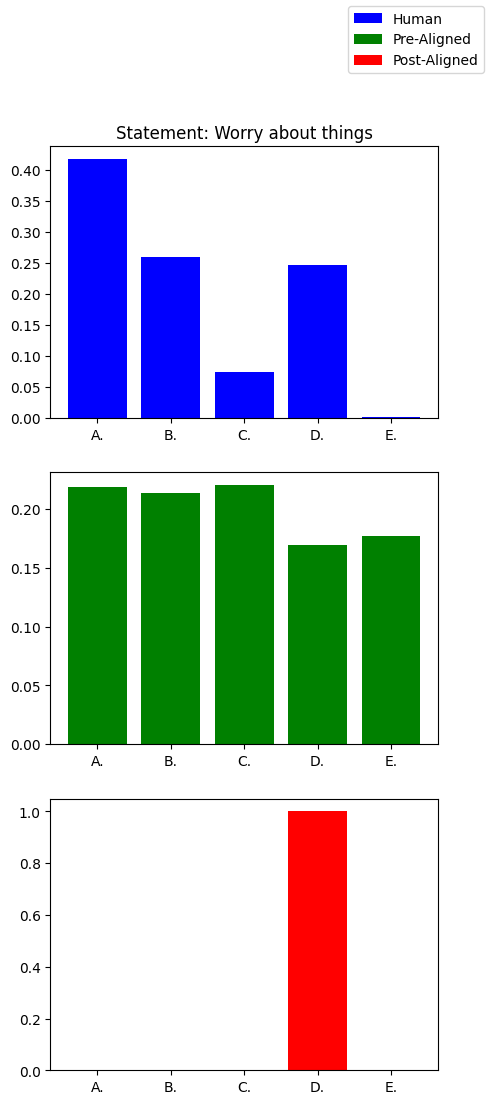

In [37]:
import matplotlib.pyplot as plt
key = 'Q0' # choose which question to view (Q0 - Q119)

human_dist = [x for x in human_distr_df[int(key[1])]]
model_dist = softmax([value["sum"] for key, value in pre_aligned_model[key].items() if key != 'human_resp'][:len(human_dist)])
model_dist_chat = softmax([value["sum"] for key, value in post_aligned_model[key].items() if key != 'human_resp'][:len(human_dist)])

fig, axs = plt.subplots(3,1, figsize=(5,12))
answer_labels = ["A.", "B.", "C.", "D.", "E."]

axs[0].set_title(f"Statement: {post_aligned_model[key]['A']['statement']}")
axs[0].bar(answer_labels[0:len(human_dist)],human_dist, label = "Human", color = "blue")
axs[1].bar(answer_labels[0:len(human_dist)],model_dist, label = "Pre-Aligned", color = "green")
axs[2].bar(answer_labels[0:len(human_dist)],model_dist_chat, label = "Post-Aligned", color = "red")

fig.legend()
